# Reinforcement Learning with PPO
In this notebook, we will implement Proximal Policy Optimization (PPO) from scratch using Keras. Unlike standard Supervised Learning where we fit a model to a fixed dataset, here we train an agent to interact with a dynamic environment (a building simulation).

## Learning Objective
- **Build a PPO Training System**: Implement the Proximal Policy Optimization algorithm, a state-of-the-art method for continuous Reinforcement Learning.
- **Create Custom Keras Models for PPO**: Subclass `keras.Model` and override `train_step` to implement complex loss functions that require manual gradient calculation.
- **Implement Generalized Advantage Estimation(GAE)**: Write a Generalized Advantage Estimation function to calculate stable training targets (advantages) from raw rewards.`
- **Control Physical Systems**: Train an agent to optimize a pysical system using real-world data

## Setup

In [1]:
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers

2025-12-11 19:12:28.057942: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765480348.080735  472825 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765480348.087794  472825 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-11 19:12:28.111197: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Loading and Normalizing Data

We are building a control system. In Control Theory terms, the Outdoor Temperature acts as an External Disturbance—a force trying to push our system away from its target state. <br>
We use the [**Jena Climate Dataset**](https://www.kaggle.com/datasets/mnassrib/jena-climate), which is sampled every 10 minutes, to drive our simulation. 

In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(
    origin=uri, fname="jena_climate_2009_2016.csv.zip"
)

df = pd.read_csv(zip_path)
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Let's split the data into training and test.

In [3]:
split_idx = int(len(df) * 0.8)

train_df = df.iloc[:split_idx].copy()
test_df = df.iloc[split_idx:].copy()

Neural networks struggle with unscaled data, so let's normalize the data.

In [4]:
# Calculate stats for normalization
temp_mean = train_df["T (degC)"].mean()
temp_std = train_df["T (degC)"].std()
pres_mean = train_df["p (mbar)"].mean()
pres_std = train_df["p (mbar)"].std()

# Normalize features


def normalize_data(df):
    return np.column_stack(
        [
            df["T (degC)"].values,  # Raw Outdoor
            (df["T (degC)"].values - temp_mean) / temp_std,  # Norm Outdoor
            (df["p (mbar)"].values - pres_mean) / pres_std,  # Norm Pressure
        ]
    )


train_data_norm = normalize_data(train_df)
test_data_norm = normalize_data(test_df)

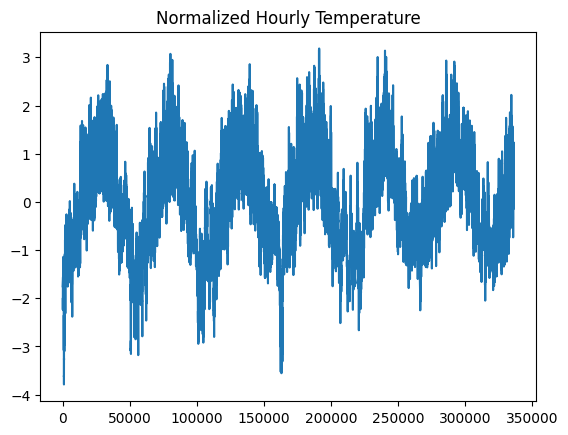

In [5]:
plt.title("Normalized Hourly Temperature")
plt.plot(train_data_norm[:, 1])
plt.show()

## Defining the Environment

In Reinforcement Learning, the "Environment" is the world the agent lives in. We build a custom Physics Simulation class (`BuildingControlEnv`) to represent a room's thermodynamics.

### The Physics Model

$$Temp_{next} = Temp_{current} + \underbrace{k \cdot (Temp_{outdoor} - Temp_{current})}_{\text{Passive Heat Loss}} + \underbrace{\text{Action} \cdot \text{HvacMaxPower}}_{\text{Active HVAC}}$$

- Insulation Factor ($k=0.1$): Represents how "leaky" the room is1. A higher value means the room temperature matches the outdoors faster.
- HVAC Power: The agent's chosen action (scaled by HVAC_POWER) adds or removes heat.


### The Reward Function (The Objective)

Designing the reward function is the most critical part of RL. We want the agent to balance two conflicting goals:
- Comfort: Keep the temperature at 22°C.
- Efficiency: Minimize electricity usage.

### Key Methods
- `reset()`: Selects a random start time from the dataset and initializes the room at 20°C .
- `step(action)`: Executes one minute of simulation. It updates the indoor temperature based on the physics model, calculates the reward, returns the next state (normalized indoor temp, outdoor temp, pressure), and increment the idx to the next timestep.

In [6]:
# Environment Params
TARGET_TEMP = 22.0  # Confortable temperature (°C).
HVAC_POWER = 5.0  # Heater strength (=Maximum temperature change in a step).
INSULATION_FACTOR = 0.1  # Insulation strength (=The effect of the outer temperature on the inner temperature.)
REWARD_SCALE = 0.1
ENERGY_COST = 0.1


class BuildingControlEnv:
    def __init__(self, data, max_steps=720):
        self.data = data
        self.max_steps = max_steps
        self.target_temp = TARGET_TEMP
        self.insulation = INSULATION_FACTOR
        self.max_power = HVAC_POWER
        self.reward_scale = REWARD_SCALE
        self.energy_cost = ENERGY_COST
        self.reset()

    def reset(self, idx=None):
        if not idx:
            # Pick random start
            self.idx = keras.random.randint(
                [1], minval=0, maxval=len(self.data) - self.max_steps - 1
            )[0].numpy()
        else:
            self.idx = idx
        self.step_cnt = 0
        self.indoor = 20.0  # Start at a slightly cold temp
        self.last_action = 0.0
        return self._get_state()

    def _get_state(self):
        # State: [Norm Indoor, Norm Outdoor, Norm Pressure, Last Action]
        indoor_norm = (self.indoor - temp_mean) / temp_std
        return keras.ops.stack(
            [
                indoor_norm,
                self.data[self.idx][1],
                self.data[self.idx][2],
                self.last_action,
            ]
        )

    def _compute_reward(self, action):
        # Physics Simulation: Heat loss + HVAC Impact
        outdoor = self.data[self.idx][0]
        self.indoor -= self.insulation * (self.indoor - outdoor)
        self.indoor += action * self.max_power

        # Reward Engineering
        error = self.indoor - self.target_temp
        comfort_penalty = -self.reward_scale * (error**2)
        comfort_penalty = max(comfort_penalty, -1.0)  # Clip

        # Add energy cost as penalty
        energy_penalty = -self.energy_cost * (action**2)

        return comfort_penalty + energy_penalty

    def step(self, action):
        total_reward = self._compute_reward(action)

        # 3. Time Step
        self.idx += 1
        self.step_cnt += 1
        self.last_action = action

        return self._get_state(), total_reward

## Implementing PPO with Subclassed Keras Models

### Actor-Critic Network
To implement Proximal Policy Optimization (PPO), we need a neural network architecture that can do two very different jobs at once. We call this the Actor-Critic architecture.

- The Actor (The "Doer"):
  - Goal: Learn what to do (the Policy $\pi$).
  - Input: The State (Indoor Temp, Outdoor Temp, Pressure).
  - Output: A Gaussian distribution defined by Mean ($\mu$) and $\log \sigma$
    - **Note**: We implement log_std as a standalone trainable variable (self.add_weight) rather than a dense layer output, making it state-independent for stability 
- The Critic (The "Judge"):
  - Goal: Learn how good a state is (the Value Function $V(s)$).
  - Input: The same State as the actor.
  - Output: A single number representing the expected sum of future rewards (e.g., "This state is worth +50 points").
  - Role: The Critic's prediction is the "baseline." If the Actor gets a reward higher than the Critic predicted, we know the action was good (Positive Advantage).


### Implementation
We subclass `keras.Model` to encapsulate both networks and their custom training logic.
- `__init__`: We define two separate Sequential models (self.actor and self.critic).
- `call(inputs)`: This is the forward pass. We run the input state through both the Actor and Critic networks and return three tensors: mu, log_std, and value.
- `train_step(data)`: This is where the PPO magic happens. We override this method to customize exactly how gradients are computed. This will be used inside `model.fit()` later.
  - Since we use TensorFlow backend, we use `tf.GradientTape()` to record the forward pass.
  - We manually calculate the **PPO Clipped Loss (Actor)** and **MSE Loss (Critic)**.
  - We apply `tape.gradient` to calculate gradients for both networks simultaneously and update them with `self.optimizer`.
  
### Loss Functions
#### Actor Loss
The PPO loss is designed to improve the policy safely. It prevents the "Cliff Problem" where a single bad update destroys the agent's knowledge.

$$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t [\min(r_t(\theta)\hat{A}_t, \text{clip}(r_t(\theta), 1-\epsilon, 1+\epsilon)\hat{A}_t)]$$
- The Ratio ($r_t$): Measures how much the new policy differs from the old one.
  - $r_t > 1$: The action is more likely now.
  - $r_t < 1$: The action is less likely now.
- The Advantage ($\hat{A}_t$): Did the action lead to a better result than expected?
- The Clip ($\epsilon=0.2$): This is the safety brake. We ignore changes that would shift the probability ratio by more than 20%. This ensures we take small, steady steps toward the optimal policy without "falling off the cliff" 

#### Critic Loss
The critic minimizes the error in reward prediction (MSE).

#### Total Loss:
We combine these two objectives, as well as the `entropy` to (A bonus for exploration) into one final number to minimize: `Total Loss = Actor_Loss + (CRITIC_WEIGHT * Critic_Loss) - (ENTROPY_WEIGHT * Entropy)`


In [8]:
# PPO Hyperparameters
CLIP_RATIO = 0.2  # PPO Trust region
ENTROPY_WEIGHT = 0.01  # Encourage exploration.
CRITIC_WEIGHT = 0.5  # Weight of Critic loss


def gaussian_log_likelihood(actions, mu, log_std):
    log_pi = keras.ops.log(2.0 * np.pi)
    std = keras.ops.exp(log_std)
    var = keras.ops.square(std)

    # Formula: -0.5 * ( (x-mu)^2/var + 2*log_std + log(2pi) )
    squared_diff = keras.ops.square(actions - mu) / var
    log_prob = -0.5 * (squared_diff + 2 * log_std + log_pi)

    # Sum across the action dimension (axis=-1)
    return keras.ops.sum(log_prob, axis=-1)


class ContinuousPPO(keras.Model):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.critic_loss = keras.losses.MeanSquaredError()

        self.critic = keras.Sequential(
            [
                layers.InputLayer(shape=(state_dim,)),
                layers.Dense(64, activation="relu"),
                layers.Dense(64, activation="tanh"),
                layers.Dense(1, activation=None),
            ]
        )

        # ACTOR: Decides 'What' (Mu) and 'How Certain' (LogStd)
        self.actor_mu = keras.Sequential(
            [
                layers.InputLayer(shape=(state_dim,)),
                layers.Dense(64, activation="relu"),
                layers.Dense(64, activation="tanh"),
                layers.Dense(action_dim, activation="tanh"),
            ]
        )
        self.actor_log_std = self.add_weight(
            name="log_std",
            shape=(1, action_dim),
            initializer="zeros",
            trainable=True,
        )

    def call(self, inputs):
        values = self.critic(inputs)
        actor_mu = self.actor_mu(inputs)
        actor_log_std = keras.ops.clip(self.actor_log_std, -3, 3)
        return actor_mu, actor_log_std, values

    def ppo_loss(
        self, new_log_probs, old_log_probs, advantages, clip_ratio=0.2
    ):
        ratio = keras.ops.exp(new_log_probs - old_log_probs)
        p1 = ratio * advantages
        p2 = (
            keras.ops.clip(ratio, 1.0 - clip_ratio, 1.0 + clip_ratio)
            * advantages
        )
        return -keras.ops.mean(keras.ops.minimum(p1, p2))

    def entropy(self, log_std):
        return keras.ops.mean(
            0.5 * (keras.ops.log(2.0 * np.pi) + 2 * log_std + 1)
        )

    def train_step(self, data):
        states = data["state"]
        actions = data["action"]
        advantages = data["advantage"]
        returns = data["return"]
        old_log_probs = data["log_prob"]

        with tf.GradientTape() as tape:
            # Prediction
            mu, log_std, values = self(states)

            # Reconstruct Gaussian Distribution
            new_log_probs = gaussian_log_likelihood(actions, mu, log_std)

            actor_loss = self.ppo_loss(
                new_log_probs, old_log_probs, advantages, CLIP_RATIO
            )
            critic_loss = self.critic_loss(returns, values)
            entropy = self.entropy(log_std)

            # KL divergence for early stopping. See the KLEarlyStopping callback defined later.
            log_ratio = new_log_probs - old_log_probs
            ratio = keras.ops.exp(log_ratio)
            approx_kl = keras.ops.mean((ratio - 1.0) - log_ratio)

            # Total Loss
            total_loss = (
                actor_loss
                + (CRITIC_WEIGHT * critic_loss)
                - (ENTROPY_WEIGHT * entropy)
            )

        # Optimization
        grads = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {
            "actor": actor_loss,
            "critic": critic_loss,
            "ent": entropy,
            "kl": approx_kl,
        }

## Define Generalized Advantage Estimation (GAE)

In Reinforcement Learning, looking at a single reward isn't enough. We need to know if a good result was just luck (noise) or part of a winning streak (signal).  **GAE** combines two pieces of information to measure this "momentum":

**The Inputs (What we know)**

These are the raw materials we feed into the GAE calculation:
- `values` (The Expectation): What the Critic predicted would happen.
  - Analogy: "I expect to get a 70 on this exam."
- `rewards` (The Reality): What actually happened in the environment.
  - Analogy: "I actually got a 90."
- `next_value` (The Horizon): The Critic's prediction for the state after the current batch ends. This connects our current experience to the future.

**The Outputs (What we use in training)**

These are the calculated signals used to update our neural networks:
- `advantages` (The Bonus $\rightarrow$ Trains the Actor): How much better was the action than expected?
  - Formula: `Accumulated Surprise` (Immediate difference + discounted future difference).
  - Meaning: If positive, the agent is performing above baseline. Do this action more.
- `returns` (The Truth $\rightarrow$ Trains the Critic): What was the actual total value of the state, in hindsight?
  - Formula: Advantage + Value
  - Meaning: The Critic was wrong. Next time, it should predict this number instead.

**The Calculation Logic**

GAE uses two steps to process these inputs:
- **Calculate Delta ($\delta$)**: The immediate surprise for one step.
  - `Delta = (Reward + Future Value) - Current Value`
- **Calculate Advantage**: The rolling surprise.
  - It looks backwards: A success tomorrow helps justify the action taken today.

In [9]:
GAMMA = 0.99  # Discount factor
LAMBDA = 0.95  # GAE smoothing


def gae(rewards, values, next_value):
    advantages = np.zeros_like(rewards)
    last_gae = 0.0

    next_values = np.concatenate((values[1:], [next_value]), axis=0)

    # Bellman Error (Deltas) = r + gamma * V(next) - V(current)
    deltas = rewards + (GAMMA * next_values) - values

    decay = GAMMA * LAMBDA
    # Iterate backwards
    for t in reversed(range(len(rewards))):
        # Recursive GAE Formula
        advantages[t] = last_gae = deltas[t] + decay * last_gae

    returns = advantages + values
    return advantages, returns

Let's check how GAE works using an example:
- Scenario: You have a goose.
- Expectation (Values): You think it lays regular eggs (Worth \$2).
- Reality (Rewards): It actually lays GOLDEN eggs (Worth \$10).

In [25]:
rewards = [10.0, 10.0, 10.0, 10.0, 10.0]  # Reality: It pays $10 daily
values = [2.0, 2.0, 2.0, 2.0, 2.0]  # Expectation: We expected only $2
next_value = 2.0  # Future expectation is also $2

advantages, returns = gae(rewards, values, next_value)

print(f"Calculated Advantage (GAE): \n{np.round(advantages, 2)}")
print(f"\nCorrected Truth (Returns):  \n{np.round(returns, 2)}")

print(
    f"\nDay 1 Return ({returns[0]:.2f}):    The goose is actually worth ${returns[0]:.2f} total."
)
print(
    f"Day 1 Advantage ({advantages[0]:.2f}): But since you expected ${values[0]}, the 'Good Surprise' is only ${advantages[0]:.2f}."
)

Calculated Advantage (GAE): 
[44.3  36.5  28.19 19.37  9.98]

Corrected Truth (Returns):  
[46.3  38.5  30.19 21.37 11.98]

Day 1 Return (46.30):    The goose is actually worth $46.30 total.
Day 1 Advantage (44.30): But since you expected $2.0, the 'Good Surprise' is only $44.30.


## PPO Training

We use a standard Python loop for data collection (the "Rollout"), but we use `model.fit()` for the optimization phase. 

### Custom Callback
KLEarlyStopping Callback: PPO is sensitive to large policy updates. If the new policy deviates too far from the old one (measured by KL Divergence), performance collapses.

We implement a custom Callback that checks KL Divergence at the end of every epoch.

If `kl > target_kl` (typically between 0.01-0.05), we set `self.model.stop_training = True`, instantly aborting the update for that batch to save the policy.

In [11]:
class KLEarlyStopping(keras.callbacks.Callback):
    def __init__(self, target_kl):
        super().__init__()
        self.target_kl = target_kl

    def on_epoch_end(self, epoch, logs=None):
        current_kl = logs.get("kl")

        if current_kl > self.target_kl:
            print(
                f"      --> Early stopping at epoch {epoch+1} (KL: {current_kl:.4f})"
            )
            self.model.stop_training = True

### The Training Loop: Rollout & Update

Training a PPO agent is different from standard Deep Learning. Since PPO is an **on-policy** method, we cannot simply pass a static dataset to `model.fit()`. Instead, we must generate our own data on the fly.

The training process is a cycle that repeats for a set number of Rollouts (iterations). Each rollout consists of three distinct phases:

#### Phase 1: Data Collection
We interact with the environment to collect a batch of fresh experience. PPO is an **On-Policy algorithm**, meaning it can only learn from data generated by its current policy. Old data is discarded.

We repeat these steps (see the inner for loop below) for STEPS_PER_ROLLOUT (lenght of one rollout episode) times:
1. **Observe & Predict**: The agent sees the current state, and the Actor network outputs a mean action ($\mu$) and a standard deviation ($\sigma$).
2. **Sample**: We sample an action from this Gaussian distribution. This adds randomness, allowing the agent to discover new strategies 
3. **Act**: We apply this action to the environment (`env.step`) and receive a **Reward** and the **Next State** 
4. **Store**: We save the State, Action, Reward, and Value Prediction into a temporary buffer 

#### Phase 2: Processing
Once the rollout is complete, we pause to analyze what happened. This is where we calculate the **Generalized Advantage Estimation (GAE)** we defined above. This converts our raw experience into high-quality training targets for the neural network.

#### Phase 3: Training
Now we update the neural network using the processed data.

We call `model.fit()` to run the PPO Loss function we defined earlier. <br>
We train on this specific batch of data for multiple epochs to squeeze out as much learning as possible, but the `KLEarlyStopping` callback watches over this phase to ensure the policy doesn't overfit and remains stable.

In [12]:
%%time
# Training Hyperparameters
ROLLOUTS = 50  # How many times we simulate and collect data (Outer Loop)
STEPS_PER_ROLLOUT = 1008  # How many environment steps (buffer size) to collect per epoch. (Inner Loop for data)
# 1008 = one week, 4320 ≈ one month
MAX_EPOCHS_PER_ROLLOUT = 50  # How many times we train on that specific batch of data (Inner Loop for the optimizer)
# KL Early Stopping terminate before this step to avoid overfitting.
BATCH_SIZE = 32  # How many times to train on the buffer collected above.
LR = 0.0003  # Learning Rate
TARGET_KL = 0.025

# Initialize
env_train = BuildingControlEnv(train_data_norm, max_steps=STEPS_PER_ROLLOUT)
model = ContinuousPPO(state_dim=4, action_dim=1)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR, global_clipnorm=0.5)
)

print("Starting Training...")
history = {
    "actor": [],
    "critic": [],
    "ent": [],
    "rewards": [],
}

for rollout in range(ROLLOUTS):
    # --- Phase 1: Data Collection ---
    print(f"    Starting Rollout {rollout}...")
    states, actions, rewards, values, log_probs = [], [], [], [], []
    state = env_train.reset()

    for step in range(STEPS_PER_ROLLOUT):
        # Observe & Predict
        mu, log_std, value_est = model(keras.ops.expand_dims(state, axis=0))

        # Sample Action (Exploration)
        std = keras.ops.exp(log_std)
        action_sample = mu + std * keras.random.normal(keras.ops.shape(mu))
        log_prob = gaussian_log_likelihood(action_sample, mu, log_std)

        # Take Action
        action = action_sample.numpy()[0, 0]
        next_state, reward = env_train.step(action)

        # Store Data
        states.append(state)
        actions.append(action)
        rewards.append(reward)
        values.append(value_est.numpy()[0, 0])
        log_probs.append(log_prob.numpy()[0])

        state = next_state

    # --- Phase 2: Processing (GAE) ---
    _, _, last_val = model(keras.ops.expand_dims(state, axis=0))
    last_val = last_val.numpy()[0, 0]

    advantages, returns = gae(rewards, values, last_val)

    # Normalize
    advantages = (advantages - keras.ops.mean(advantages)) / (
        keras.ops.std(advantages) + 1e-8
    )
    returns = (returns - keras.ops.mean(returns)) / (
        keras.ops.std(returns) + 1e-8
    )

    # --- Phase 3: Training ---
    dataset = {
        "state": np.array(states),
        "action": np.array(actions).reshape(-1, 1),
        "advantage": advantages,
        "return": returns,
        "log_prob": np.array(log_probs),
    }
    rollout_history = model.fit(
        dataset,
        batch_size=BATCH_SIZE,
        epochs=MAX_EPOCHS_PER_ROLLOUT,
        verbose=0,
        callbacks=[KLEarlyStopping(target_kl=TARGET_KL)],
    )

    history["actor"].append(
        keras.ops.mean(rollout_history.history["actor"]).numpy()
    )
    history["critic"].append(
        keras.ops.mean(rollout_history.history["critic"]).numpy()
    )
    history["ent"].append(
        keras.ops.mean(rollout_history.history["ent"]).numpy()
    )
    history["rewards"].append(keras.ops.sum(rewards).numpy())

    print(
        f"    Rollout {rollout+1} Result - Reward: {history['rewards'][-1]:.2f}"
    )

I0000 00:00:1765480352.271945  472825 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 683 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


Starting Training...
    Starting Rollout 0...


I0000 00:00:1765480367.786944  472867 service.cc:148] XLA service 0x7f6c3800e0f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765480367.786987  472867 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-11 19:12:47.841660: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765480368.069785  472867 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1765480369.090409  472867 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


      --> Early stopping at epoch 30 (KL: 0.0288)
    Rollout 1 Result - Reward: -1112.41
    Starting Rollout 1...
      --> Early stopping at epoch 3 (KL: 0.0255)
    Rollout 2 Result - Reward: -975.75
    Starting Rollout 2...
      --> Early stopping at epoch 9 (KL: 0.0253)
    Rollout 3 Result - Reward: -942.31
    Starting Rollout 3...
      --> Early stopping at epoch 12 (KL: 0.0287)
    Rollout 4 Result - Reward: -921.11
    Starting Rollout 4...
      --> Early stopping at epoch 19 (KL: 0.0317)
    Rollout 5 Result - Reward: -845.84
    Starting Rollout 5...
      --> Early stopping at epoch 16 (KL: 0.0293)
    Rollout 6 Result - Reward: -777.18
    Starting Rollout 6...
      --> Early stopping at epoch 14 (KL: 0.0275)
    Rollout 7 Result - Reward: -718.47
    Starting Rollout 7...
      --> Early stopping at epoch 24 (KL: 0.0691)
    Rollout 8 Result - Reward: -708.98
    Starting Rollout 8...
      --> Early stopping at epoch 6 (KL: 0.0361)
    Rollout 9 Result - Reward: -

## Evaluation

After training, we switch the model to inference mode.

During training, we sampled actions from a Gaussian distribution (exploration). For evaluation, we use the mean mu directly (exploitation) to check the optimal performance.

In [13]:
TEST_STEPS = 2000
test_env = BuildingControlEnv(test_data_norm, max_steps=TEST_STEPS)
state = test_env.reset()

indoor_log, outdoor_log, action_log = [], [], []

for t in range(TEST_STEPS):
    # Use Mean (mu) for deterministic evaluation
    mu, _, _ = model(keras.ops.expand_dims(state, axis=0), training=False)
    action = mu.numpy()[0, 0]

    state, _ = test_env.step(action)

    indoor_log.append(test_env.indoor)
    # Denormalize outdoor for plotting
    outdoor_real = (state[1] * temp_std) + temp_mean
    outdoor_log.append(outdoor_real)
    action_log.append(action)

Let's plot the Indoor Temp controlled by HVAC actions vs. Target Temp to visually verify if the agent learned to anticipate weather changes.

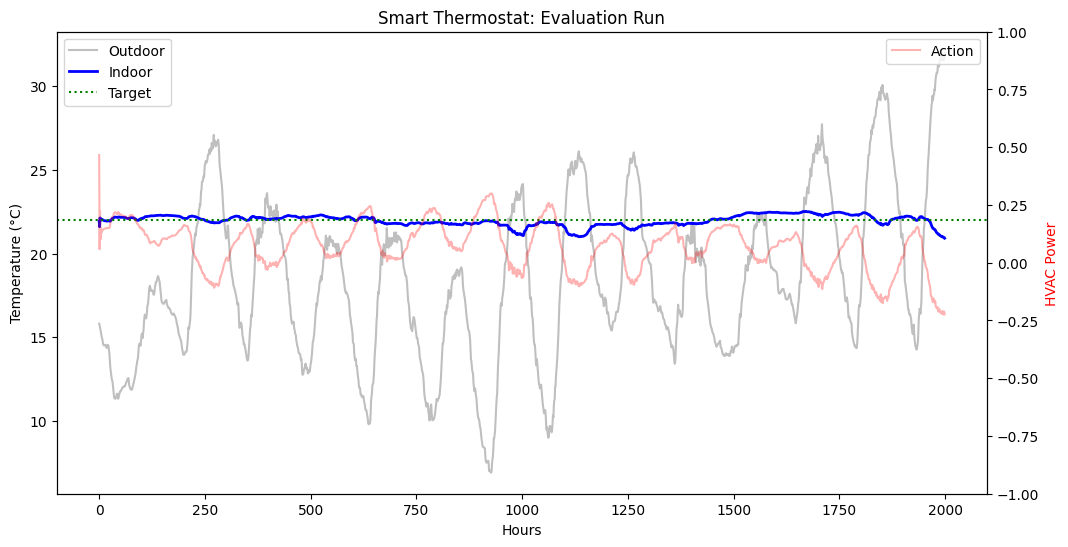

In [14]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel("Hours")
ax1.set_ylabel("Temperature (°C)")
ax1.plot(outdoor_log, color="gray", alpha=0.5, label="Outdoor")
ax1.plot(indoor_log, color="blue", linewidth=2, label="Indoor")
ax1.axhline(y=TARGET_TEMP, color="green", linestyle=":", label="Target")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.set_ylabel("HVAC Power", color="red")
ax2.plot(action_log, color="red", alpha=0.3, label="Action")
ax2.set_ylim(-1.0, 1.0)
ax2.legend(loc="upper right")

plt.title("Smart Thermostat: Evaluation Run")
plt.show()

Copyright 2025 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.